<h1>BINARY</h1>
<h1>Dataset Pre-processing</h1>


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler

<h3>Loading the original dataset</h3>

In [3]:
diabetes_binary_ds = pd.read_csv('diabetes_binary.csv')
diabetes_binary_ds.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


<h3>Checking for class imbalance</h3>
<h5>Target classes:</h5>
<p>0: Healthy</p>
<p>1: Diabetic/Prediabetic</p>

In [4]:
class_dist = diabetes_binary_ds["Diabetes_binary"].value_counts()
print("\n Count per Class: \n", class_dist)

class_percent = (class_dist/ diabetes_binary_ds.shape[0]) * 100
print("\n Percentage per Class: \n", class_percent)


 Count per Class: 
 0.0    218334
1.0     35346
Name: Diabetes_binary, dtype: int64

 Percentage per Class: 
 0.0    86.066698
1.0    13.933302
Name: Diabetes_binary, dtype: float64


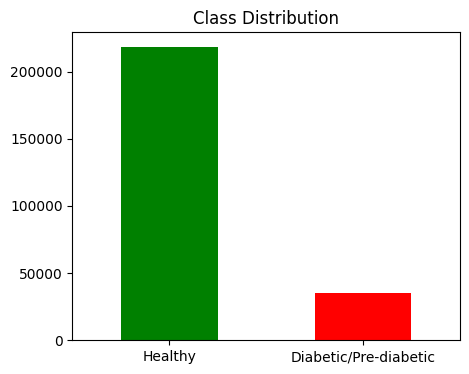

In [5]:

plt.figure(figsize=(5,4))
class_dist.plot(kind="bar", color=["green", "red"])
plt.xticks(ticks=range(len(class_dist)), labels=["Healthy", "Diabetic/Pre-diabetic"], rotation=0)
plt.title("Class Distribution")
plt.show()

<h3>Checking for missing values and labels</h3>

In [6]:
#1. check for missing target labels
missing_labels = diabetes_binary_ds["Diabetes_binary"].isnull().sum()
print('Number of missing labels: ', missing_labels)

#2. check for missing values
features = diabetes_binary_ds.drop(columns=['Diabetes_binary'])
missing_values = features.isnull().sum()
print('\nNumber of missing values: ', missing_labels)

Number of missing labels:  0

Number of missing values:  0


<h1>Data Cleaning</h1>

<p>Creating a new dataset for processing</p>

In [7]:
diabetes_binary_ds_copy = diabetes_binary_ds.copy()
diabetes_binary_ds_copy.to_csv('processed_diabetes_binary.csv', index=False)

diabetes_processed = pd.read_csv('processed_diabetes_binary.csv')

<h2>Reducing Dimensionality</h2>

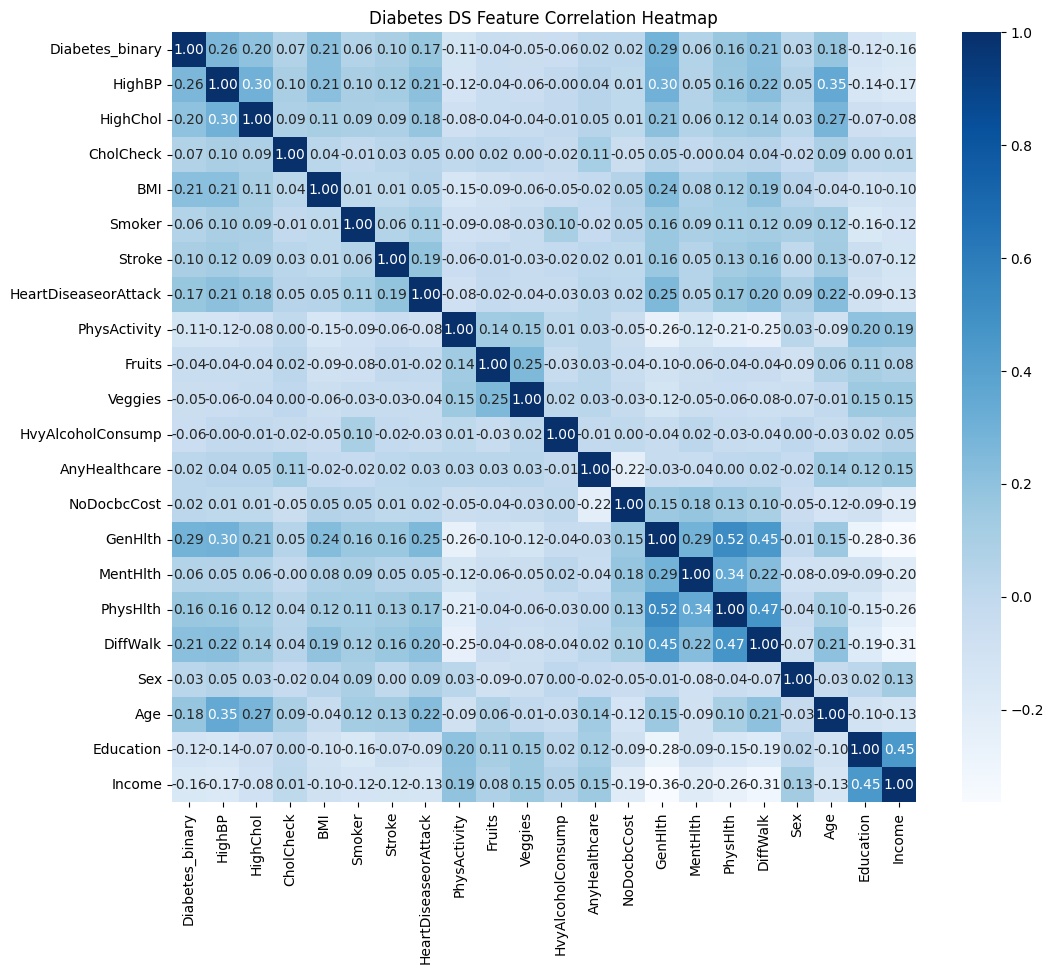

Diabetes_binary         1.000000
GenHlth                 0.289207
HighBP                  0.261688
BMI                     0.214434
DiffWalk                0.212789
HighChol                0.198873
Age                     0.178022
HeartDiseaseorAttack    0.170797
PhysHlth                0.164214
Stroke                  0.095044
CholCheck               0.065605
MentHlth                0.060791
Smoker                  0.060457
Sex                     0.031811
NoDocbcCost             0.022693
AnyHealthcare           0.021645
Fruits                 -0.038960
Veggies                -0.053604
HvyAlcoholConsump      -0.057135
PhysActivity           -0.114168
Education              -0.120584
Income                 -0.158980
dtype: float64


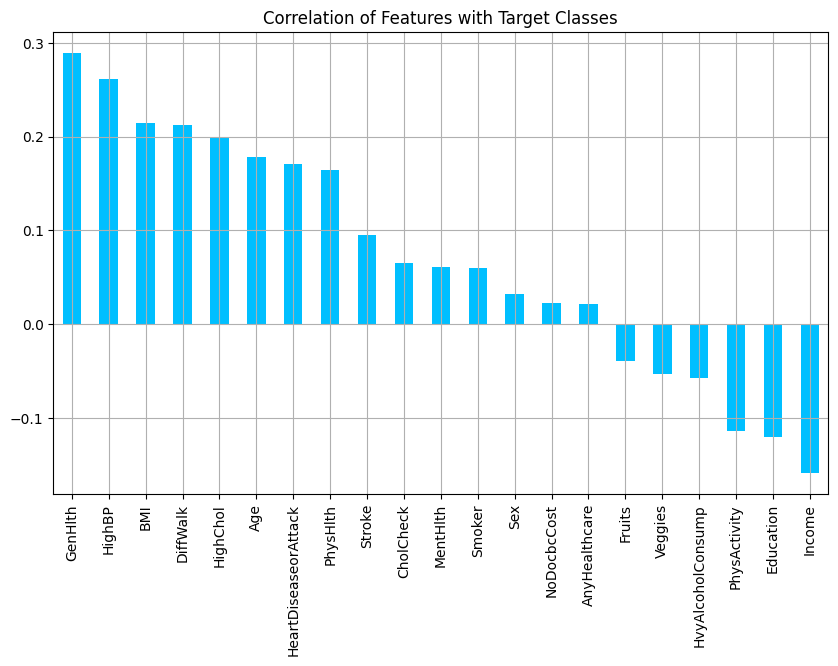

Low correlation features: ['Fruits', 'AnyHealthcare', 'NoDocbcCost', 'Sex']


In [17]:
corr_matrix = diabetes_processed.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Diabetes DS Feature Correlation Heatmap")
plt.show()
      
corr_target = diabetes_processed.corrwith(diabetes_processed['Diabetes_binary']).sort_values(ascending=False)
print(corr_target)

plt.figure(figsize=(10,6))
corr_target.drop('Diabetes_binary').plot(kind='bar', color='deepskyblue')
plt.title('Correlation of Features with Target Classes')
plt.grid(True)
plt.show()

# Identify low correlation features with the target
low_corr_features = corr_matrix['Diabetes_binary'][abs(corr_matrix['Diabetes_binary']) < 0.05].index.tolist()
print(f"Low correlation features: {low_corr_features}")

<h3>Task 1: Removing Outliers</h3>

In [12]:
# Using IsolationForest for anomaly scores and 1.5 * IQR for classifying outliers. 
# IsolationForest isolates a "tree" or data point. Depending on how quickly it is isolated, it receives an anomaly score. Fewer splits = more anomalous.
# The higher the score, the more anomalous. 
# Running in test mode it should remove +-400 outliers.
 
pre = len(diabetes_processed)
isolation_forest = IsolationForest()
isolation_forest.fit(diabetes_processed)
anomaly_scores = isolation_forest.decision_function(diabetes_processed)

Q1 = np.percentile(anomaly_scores, 25)
Q3 = np.percentile(anomaly_scores, 75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_indices = ((anomaly_scores < lower_bound) | (anomaly_scores > upper_bound))

diabetes_processed = diabetes_processed[~outlier_indices]
anomaly_scores_filtered = anomaly_scores[~outlier_indices]

num_removed = pre - len(diabetes_processed)
print(f"removed {num_removed} outliers")

removed 905 outliers


In [19]:
print(len(diabetes_processed))
#dataset size after removing outliers

253314


<h3>Task 2: Scaling Features </h3>

In [20]:

def scale_continuous_features(df):
    # Find continuous features
    continuous_features = df.columns[1:]
    
    if len(continuous_features) == 0:
        print("No continuous features found in the DataFrame.")
        return df
    
    # Scale the continuous features
    scaler = MinMaxScaler()
    df_scaled = df.copy()
    df_scaled[continuous_features] = scaler.fit_transform(df[continuous_features])
    
    return df_scaled

diabetes_processed = scale_continuous_features(diabetes_processed)

diabetes_processed.head(5)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,0.325581,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.00,0.6,0.5,1.0,0.0,0.666667,0.6,0.285714
1,0.0,0.0,0.0,0.0,0.151163,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.50,0.0,0.0,0.0,0.0,0.500000,1.0,0.000000
2,0.0,1.0,1.0,1.0,0.186047,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.00,1.0,1.0,1.0,0.0,0.666667,0.6,1.000000
3,0.0,1.0,0.0,1.0,0.174419,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.833333,0.4,0.714286
4,0.0,1.0,1.0,1.0,0.139535,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.25,0.1,0.0,0.0,0.0,0.833333,0.8,0.428571
